# New-York Taxi fare prediction 

## Data exploration

In [59]:
#load default python modules
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('seaborn-whitegrid')

In [4]:
df_train = pd.read_csv('all/train.csv', nrows = 2_000_000, parse_dates=["pickup_datetime"])


In [5]:
#first rows:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      datetime64[ns]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 122.1+ MB


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [6]:
df_train = df_train[df_train.fare_amount>0]


Text(0.5,1,'Histogram')

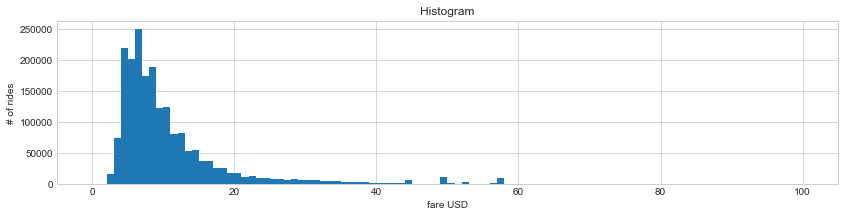

In [7]:
#histogram for fare

df_train[df_train.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare USD')
plt.ylabel('# of rides')
plt.title('Histogram')

In [8]:
#missing values

df_train.isnull().sum()
df_train = df_train.dropna(axis = 'rows', how = 'any')
print(f'The new dataset has {len(df_train)} rows')

The new dataset has 1999853 rows


In [9]:
#duplicated values
print(f'there is {df_train.duplicated().sum()} duplicated values')

there is 0 duplicated values


## Test Data

In [10]:
df_test = pd.read_csv('all/test.csv', parse_dates=['pickup_datetime'])

In [11]:
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1


In [12]:
df_test.describe()


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


## Data on map

In [13]:
# minimum and maximum longitude test set

min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()), \
max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())

(-74.263242, -72.986532)

In [14]:
# minimum and maximum latitude test
min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()), \
max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())

(40.568973, 41.709555)

In [15]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png') 

In [16]:
df_train = df_train[select_within_boundingbox(df_train, BB)]


In [17]:
# Plot on map function:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2, color = False):
    fig, axs = plt.subplots(1, 2, figsize=(18,22))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

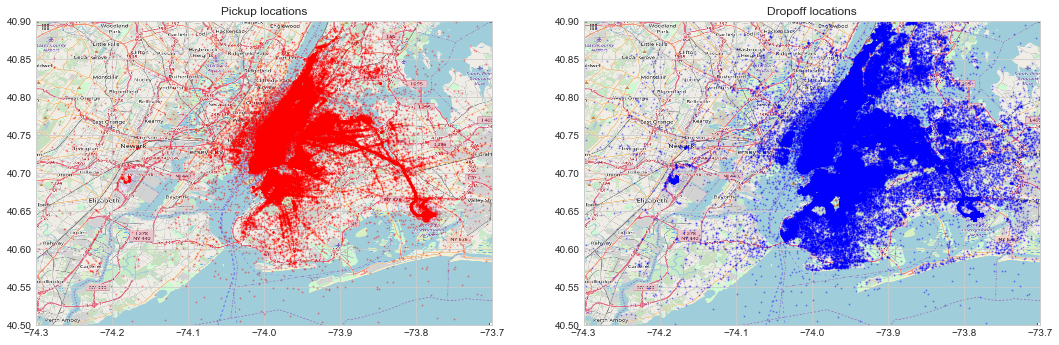

In [18]:
#Train Data
plot_on_map(df_train, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

#We can see that there is more people ordering a taxi from nyc manathan to outside manathan than the opposite

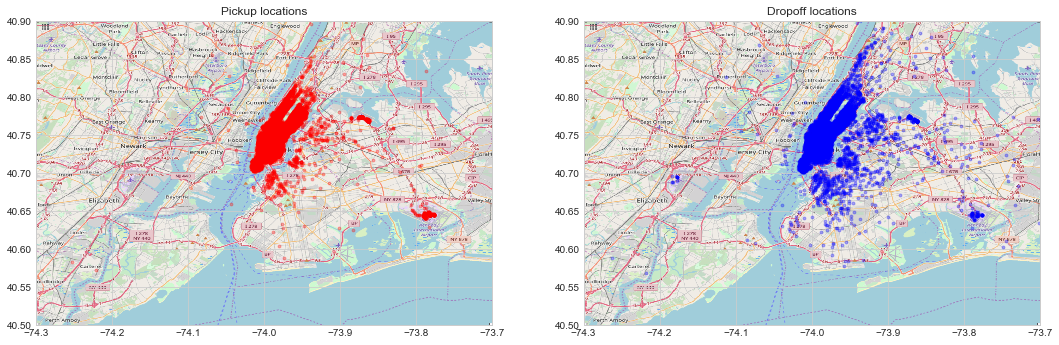

In [19]:
#test Data
plot_on_map(df_test, BB_zoom, nyc_map_zoom, s=8, alpha=0.3)


## Black and White map

In [20]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('w', 'w')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = select_within_boundingbox(df, BB)
    ax.set_facecolor('black')
    ax.grid(False)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.2)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.2)
    


I have decided to prit the drop-off and pick-up location the same color. In fact they overlapse each other in many case, which is not very interesting for our case. What we can see with this techniques is that most of the rides are within Mannathan. 

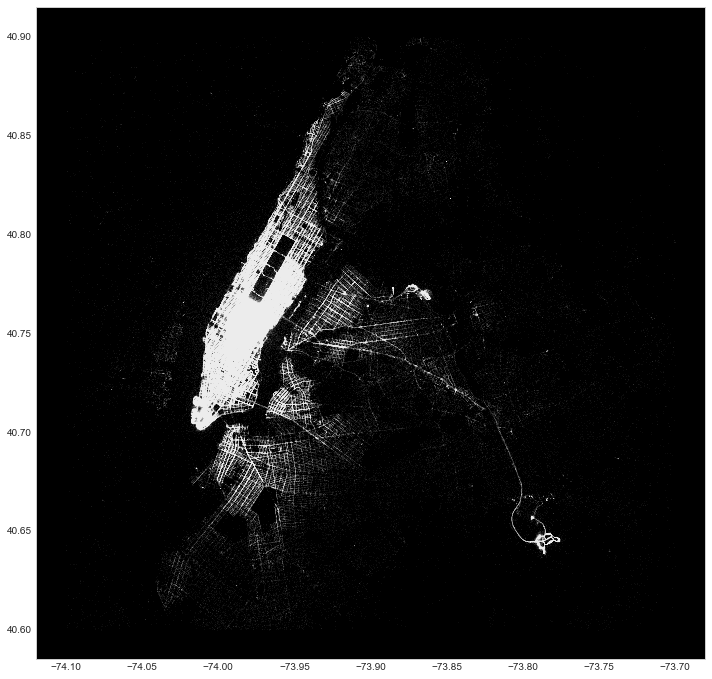

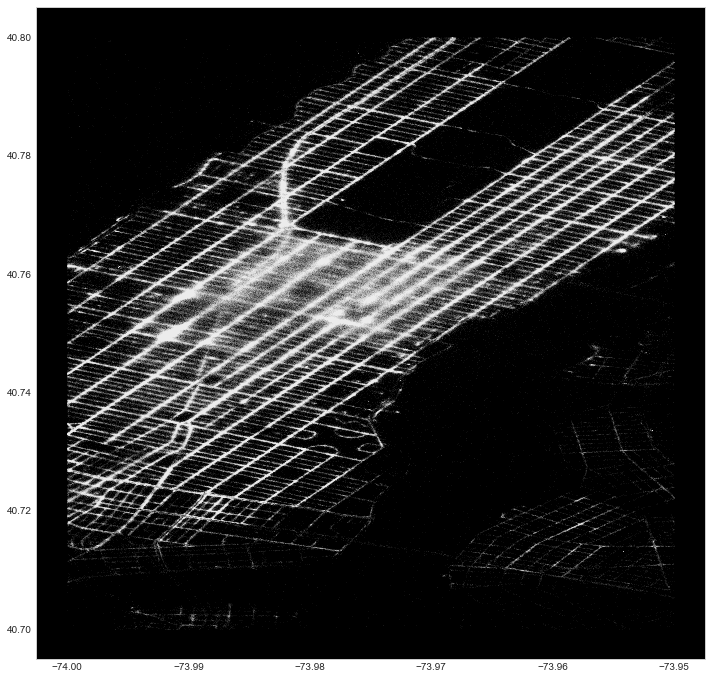

In [21]:
plot_hires(df_train, (-74.1, -73.7, 40.6, 40.9))
plot_hires(df_train, (-74, -73.95, 40.7, 40.8))


## Data Cleaning

Let's remove data point that fell into water = outliers


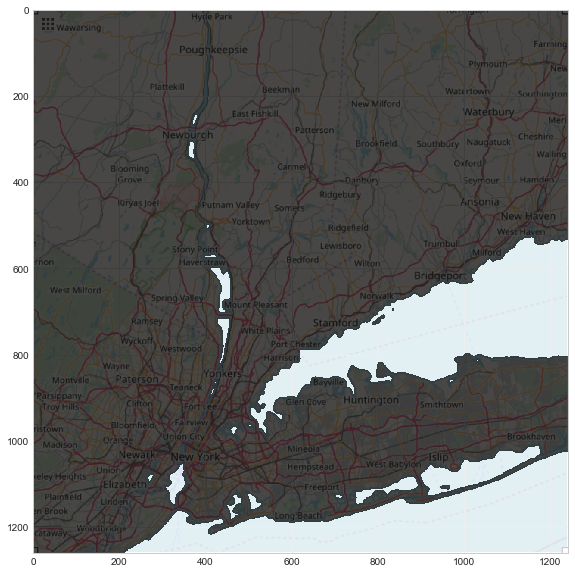

In [22]:
# read nyc mask and turn into boolean map with
# land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9

plt.figure(figsize=(10,10))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, zorder=1, alpha=0.7); # note: True is show in black, False in white.


In [23]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

In [24]:
print('Old size: %d' % len(df_train))
df_train = remove_datapoints_from_water(df_train)
print('New size: %d' % len(df_train))

Old size: 1957875
New size: 1957487


### Density map


let's find out  the distance between two points

In [29]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

# First calculate two arrays with datapoint density per sq mile
n_lon, n_lat = 200, 200 # number of grid bins per longitude, latitude dimension
density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # prepare arrays


bins_lon = np.zeros(n_lon+1) # bin
bins_lat = np.zeros(n_lat+1) # bin
delta_lon = (BB[1]-BB[0]) / n_lon # bin longutide width
delta_lat = (BB[3]-BB[2]) / n_lat # bin latitude height
bin_width_miles = distance(BB[2], BB[1], BB[2], BB[0]) / n_lon # bin width in miles
bin_height_miles = distance(BB[3], BB[0], BB[2], BB[0]) / n_lat # bin height in miles
for i in range(n_lon+1):
    bins_lon[i] = BB[0] + i * delta_lon
for j in range(n_lat+1):
    bins_lat[j] = BB[2] + j * delta_lat
    
# Digitize per longitude, latitude dimension
inds_pickup_lon = np.digitize(df_train.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(df_train.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(df_train.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(df_train.dropoff_latitude, bins_lat)

# Count per grid bin
# note: as the density_pickup will be displayed as image, the first index is the y-direction, 
#       the second index is the x-direction. Also, the y-direction needs to be reversed for
#       properly displaying (therefore the (n_lat-j) term)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy
    

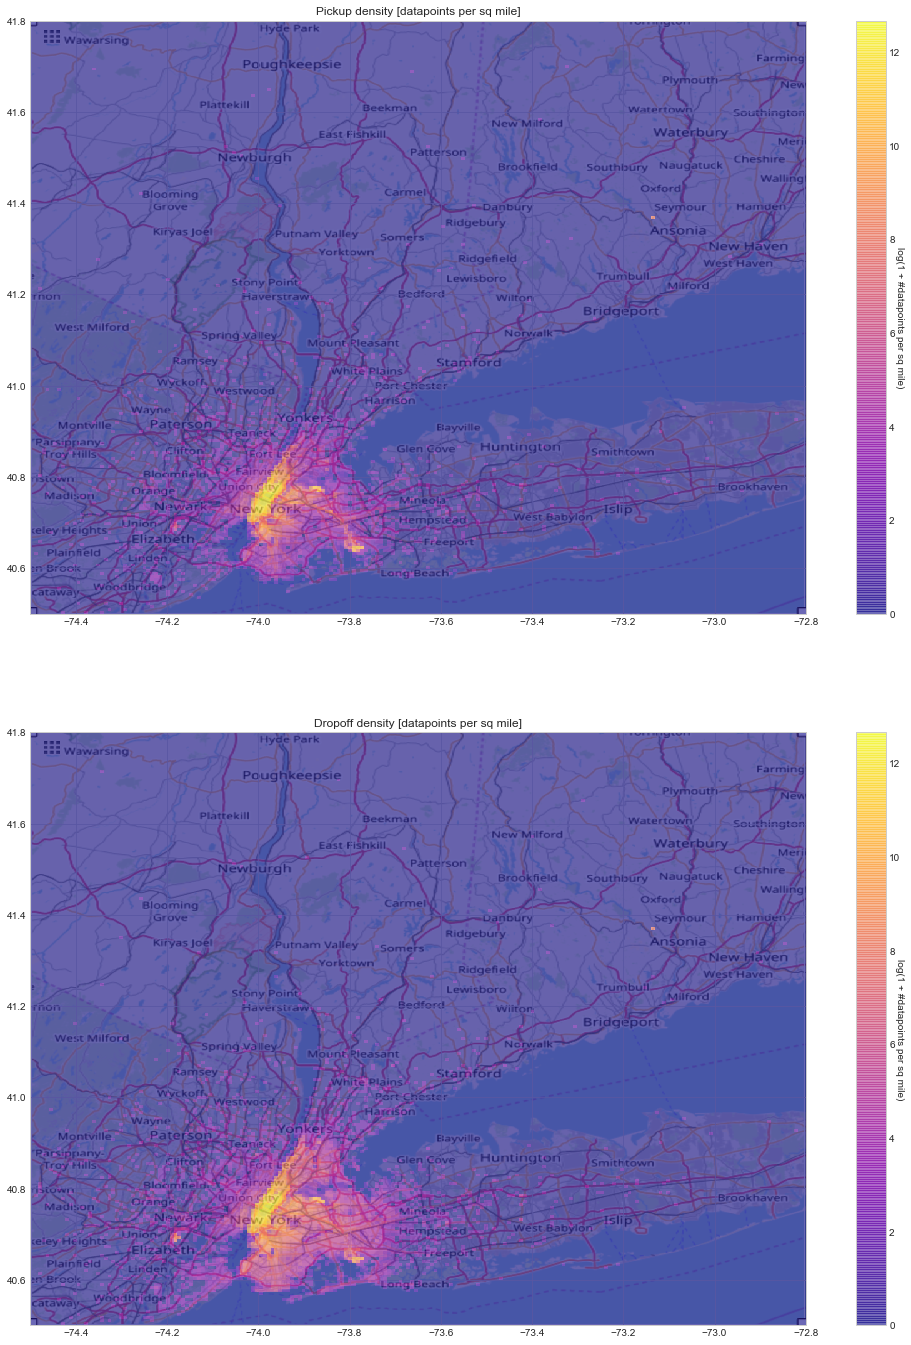

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(18, 24))
axs[0].imshow(nyc_map, zorder=0, extent=BB);
im = axs[0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[0].set_title('Pickup density [datapoints per sq mile]')
cbar = fig.colorbar(im, ax=axs[0])
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)
################################################################
axs[1].imshow(nyc_map, zorder=0, extent=BB);
im = axs[1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[1].set_title('Dropoff density [datapoints per sq mile]')
cbar = fig.colorbar(im, ax=axs[1])
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)

Test Intuitions

In [39]:
# add new column to dataframe with distance in miles
df_train['distance_miles'] = distance(df_train.pickup_latitude, df_train.pickup_longitude, 
                                      df_train.dropoff_latitude, df_train.dropoff_longitude)


count    1.957487e+06
mean     2.068183e+00
std      2.345919e+00
min      0.000000e+00
25%      7.789545e-01
50%      1.337209e+00
75%      2.431892e+00
max      7.132624e+01
Name: distance_miles, dtype: float64

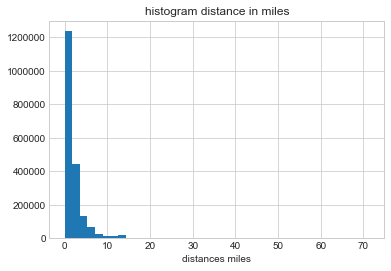

In [48]:
df_train.distance_miles.hist(bins=40)
plt.xlabel('distances miles')
plt.title('histogram distance in miles')
df_train.distance_miles.describe()


Most of the rides are less than 5 miles which is pretty small

#### Scatter distance - fare

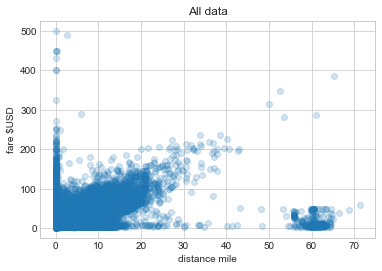

In [63]:
plt.scatter(df_train.distance_miles, df_train.fare_amount, alpha=0.2)
plt.xlabel('distance mile')
plt.ylabel('fare $USD')
plt.title('All data')
plt.show()


In [64]:
# remove datapoints with distance <0.05 miles
idx = (df_train.distance_miles >= 0.05)
print('Old size: %d' % len(df_train))
df_train = df_train[idx]
print('New size: %d' % len(df_train))

Old size: 1957487
New size: 1926230
